<a href="https://colab.research.google.com/github/eumiejhong/Anti-spoofing/blob/master/TransferLearningAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls "/content/drive/My Drive/images"

fake_ids  real-ids


In [3]:
import numpy as np
import tensorflow as tf

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
directory = "/content/drive/My Drive/images"

In [6]:
from skimage.feature import local_binary_pattern

In [7]:
from keras.models import Sequential
get_ipython().magic('matplotlib inline')
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
import pandas as pd

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, merge, Reshape, Activation

from sklearn.metrics import log_loss

Using TensorFlow backend.


In [8]:
!pip install scikit-plot

In [9]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint
from keras import layers, models, Model, optimizers
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [10]:
from tqdm import tqdm

In [11]:
import glob
fake = glob.glob('/content/drive/My Drive/images/fake_ids/*.*')
real = glob.glob('/content/drive/My Drive/images/real-ids/*.*')

data = []
labels = []

for i in tqdm(fake):   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(0)

for i in tqdm(real):   
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb', 
    target_size= (224,224))
    image=np.array(image)
    data.append(image)
    labels.append(1)

datagen = ImageDataGenerator(rescale=1/255.,validation_split=None)

data = np.array(data)
labels = np.array(labels)

100%|██████████| 857/857 [10:22<00:00,  1.38it/s]


In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, ytrain, ytest = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

In [13]:
#training_generator = datagen.flow(X_train, ytrain, batch_size=64,subset='training',seed=7)
#validation_generator = datagen.flow(X_train, ytrain, batch_size=64,subset='validation',seed=7)

In [14]:
from keras.models import Model

def vgg16_model(img_rows, img_cols, channel=1, num_classes=None):

  model = VGG16(weights='imagenet', include_top=True)

  model.layers.pop()

  model.outputs = [model.layers[-1].output]

  model.layers[-1].outbound_nodes = []

  x=Dense(num_classes, activation='softmax')(model.output)

  model=Model(model.input,x)

#To set the first 2 layers to non-trainable (weights will not be updated)

  for layer in model.layers[:2]:

    layer.trainable = False

# Learning rate is changed to 0.001
  sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

ytrain= labels

le = LabelEncoder()

ytrain = le.fit_transform(ytrain)

ytrain=to_categorical(ytrain)

ytrain=np.array(ytrain)

from sklearn.model_selection import train_test_split
X_train, X_valid, ytrain, yvalid=train_test_split(data,ytrain,test_size=0.2, random_state=42)

In [15]:
#Fine-tuning model

img_rows, img_cols = 224, 224 # Resolution of inputs
channel = 3
num_classes = 2 
batch_size = 16 
nb_epoch = 10
from math import ceil

n_points = len(X_train)

steps_per_epoch = ceil(n_points / batch_size)
print(steps_per_epoch)

76


In [16]:
!pip install h5py

In [17]:
import h5py

In [18]:
#!pip install tensorflow-gpu==1.15

In [19]:
# Load our model
model = vgg16_model(img_rows, img_cols, channel, num_classes)

#checkpoint = ModelCheckpoint(r'/content/gdrive/My Drive/sign_classifier.h5')
#cp_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint,save_best_only=True, save_weights_only=True, verbose=1)

#model = models.load_model(r'/content/gdrive/My Drive/sign_classifier.h5')

model.summary()
# Start Fine-tuning
model.fit(X_train, ytrain,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(X_valid, yvalid))

# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

# Cross-entropy loss score
score = log_loss(yvalid, predictions_valid)

553467904/553467096 [==============================] - 34s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [43]:
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
!pip install scikit-plot

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc

In [42]:
score_train = model.evaluate(X_train, ytrain, verbose=0)
score_valid = model.evaluate(X_valid, yvalid, verbose=0)
print('Train data accuracy %s: %.2f%%' % (model.metrics_names[1], score_train[1]*100))
print('Valid data accuracy %s: %.2f%%' % (model.metrics_names[1], score_valid[1]*100))

Train data accuracy accuracy: 100.00%
Valid data accuracy accuracy: 100.00%


In [22]:
# Cross-entropy loss score
print('Model log loss {}'.format(log_loss(yvalid, predictions_valid)))

Model log loss 0.13873687984519883


In [44]:
from keras.models import load_model
 
# load model
model = load_model('model.h5')

array([0.1139311, 0.8860689], dtype=float32)

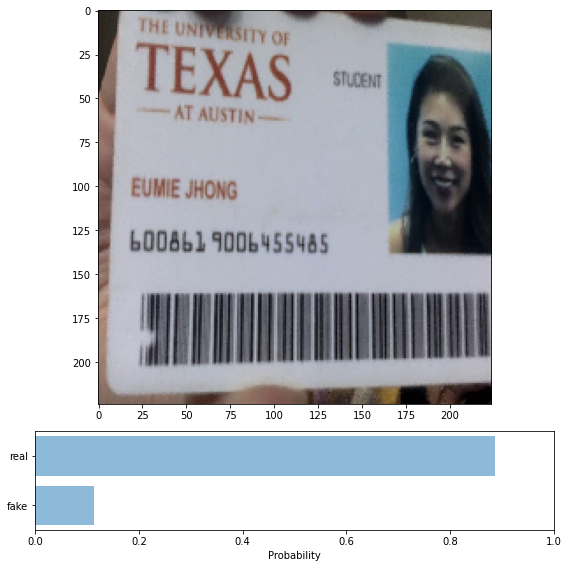

In [28]:
import numpy as np
from keras.preprocessing import image
import matplotlib.gridspec as gridspec

def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

def plot_preds(img, preds):
    """Displays image and the top-n predicted probabilities in a bar graph
    Args:
        preds: list of predicted labels and their probabilities
    """
    labels = ("fake", "real")
    gs = gridspec.GridSpec(2, 1, height_ratios=[4, 1])
    plt.figure(figsize=(8,8))
    plt.subplot(gs[0])
    plt.imshow(np.asarray(img))
    plt.subplot(gs[1])
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probability')
    plt.xlim(0, 1)
    plt.tight_layout()

#real ids

img = image.load_img(r'/content/drive/My Drive/images/real-ids/frame0348.jpg', target_size=(224, 224))
preds = predict(model, img)
plot_preds(np.asarray(img), preds)
preds

array([0.11340401, 0.886596  ], dtype=float32)

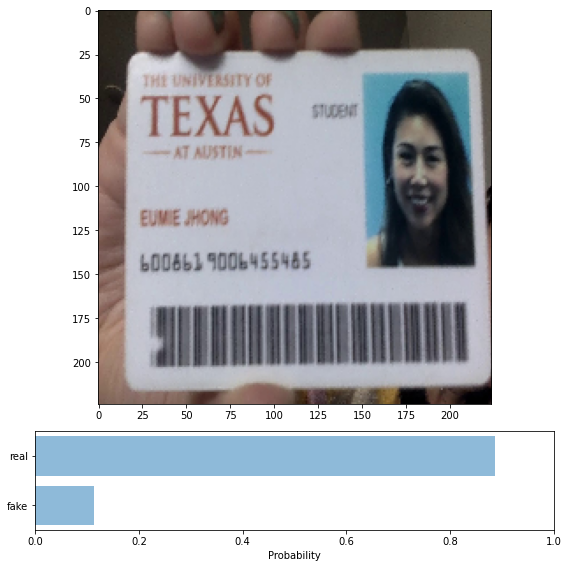

In [29]:
img_2 = image.load_img(r'/content/drive/My Drive/images/real-ids/frame0494.jpg', target_size=(224, 224))
preds = predict(model, img_2)
plot_preds(np.asarray(img_2), preds)
preds

array([0.8501328 , 0.14986716], dtype=float32)

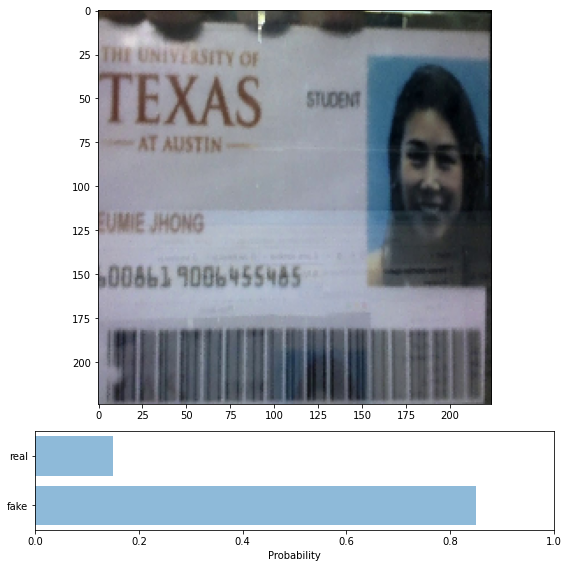

In [35]:
#fake ids
img_3 = image.load_img(r'/content/drive/My Drive/images/fake_ids/frame0194.jpg', target_size=(224, 224))
preds = predict(model, img_3)
plot_preds(np.asarray(img_3), preds)
preds

array([0.85012066, 0.1498793 ], dtype=float32)

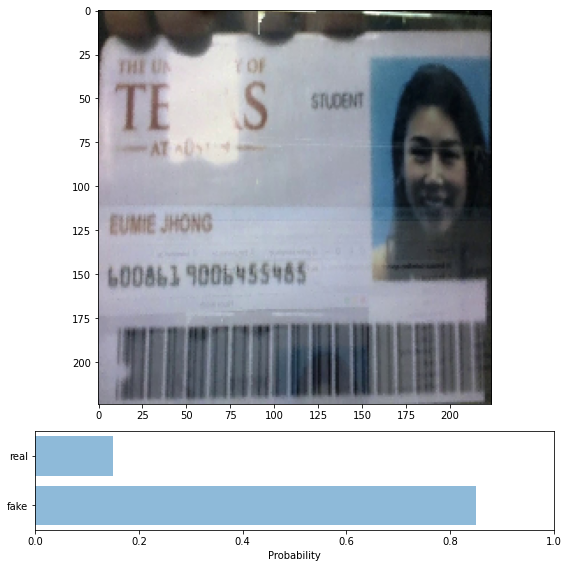

In [34]:
img_4 = image.load_img(r'/content/drive/My Drive/images/fake_ids/frame0149.jpg', target_size=(224, 224))
preds = predict(model, img_4)
plot_preds(np.asarray(img_4), preds)
preds